<a href="https://colab.research.google.com/github/chenyu313/Colaboratory_note/blob/main/pytorch_lightning%E5%85%A5%E9%97%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 环境

In [ ]:
! pip install --quiet "seaborn" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "lightning>=2.0.0rc0" "ipython[notebook]==7.9.0" "pandas" "torchmetrics >=0.11.0" "torch>=1.8.1, <1.14.0" "torchmetrics>=0.7, <0.12"

In [ ]:
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

## 一个简单的例子
这里有一个最简单的例子，只有一个训练循环(没有验证，没有测试)。

In [5]:
class MNISTModel(L.LightningModule):
  def __init__(self):
    #初始化
    super().__init__()
    self.l1=torch.nn.Linear(28*28,10)
  
  def forward(self,x):
    #前向传播
    return torch.relu(self.l1(x.view(x.size(0),-1)))

  def training_step(self,batch,batch_nb):
    #训练
    x,y=batch
    loss=F.cross_entropy(self(x),y)

  def configure_optimizers(self):
    #优化器
    return torch.optim.Adam(self.parameters(),lr=0.02)
  


通过使用Trainer将自动获得：  
* 张量日志
* 模型检查点
* 训练和验证循环
* 早停

In [6]:
#初始化模型
mnist_model=MNISTModel()
#从数据集中获取数据
train_ds=MNIST(PATH_DATASETS,train=True, download=True, transform=transforms.ToTensor())
train_loader=DataLoader(train_ds,BATCH_SIZE)

#初始化训练器
trainer=L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3
)
# 开始训练模型 ⚡
trainer.fit(mnist_model, train_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | 

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/loops/optimization/automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


## 一个更完整的MNIST闪电模块示例
注意以下函数在做什么：
* prepare_data() 
  * 我们可以从这里下载数据集。我们指向我们想要的数据集，并要求torchvision的MNIST数据集类下载，如果数据集没有找到那里。
  * 注意，我们没有在这个函数中进行任何状态赋值(即self.something=…)

* setup(stage) 
  * 从文件中加载数据，并为每个批量(train, val, test)准备PyTorch张量数据集。
  * setup程序需要一个“stage”参数，用于分离“fit”和“test”的逻辑。
  * 如果你不介意一次加载所有的数据集，你可以设置一个条件，允许“fit”相关的设置和“test”相关的设置在None传递到阶段时运行(或者完全忽略它并排除任何条件)。
  * 注意，这是在所有gpu上运行的，在这里进行状态分配是安全的

* x_dataloader()
  * train_dataloader()， val_dataloader()和test_dataloader()都返回PyTorch DataLoader实例，这些实例是通过包装我们在setup()中准备的各自的数据集创建的。

In [8]:
class LitMNIST(L.LightningModule):
  #⚡闪电模型
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):
        super().__init__()

        # 将初始化参数设置为类属性
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # 硬编码一些数据集特定的属性
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # 定义PyTorch模型
        self.model = nn.Sequential(
            nn.Flatten(), #展开
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),  #激活函数
            nn.Dropout(0.1), #暂退法，防止过拟合
            nn.Linear(hidden_size, hidden_size), #隐藏层
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # 调用self.log将为你在TensorBoard中显示标量
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # 调用self.log将为你在TensorBoard中显示标量
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # 下载
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # 为数据加载器分配train/val数据集
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # 为数据加载器分配test数据集
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [9]:
# 开始训练
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


## 测试
如果你刚刚训练了一个模型，你可以调用trainer.test()， Lightning会自动使用保存最好的检查点(以val_loss为条件)进行测试。

In [10]:
trainer.test()

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkp

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9284999966621399     │
│         test_loss         │    0.24773144721984863    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.24773144721984863, 'test_acc': 0.9284999966621399}]

## 一些建议
您可以继续调用trainer.fit(model)多次，只要您想继续训练

In [11]:
trainer.fit(model)

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
-----------------------------------------------------
0 | model   

Sanity Checking: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


在Colab中，你可以使用TensorBoard神奇的功能来查看Lightning为你创建的日志!

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.431031,0.8914,NaN,NaN
1,0.310261,0.9130,NaN,NaN
2,0.262309,0.9264,NaN,NaN
3,NaN,NaN,0.247731,0.9285


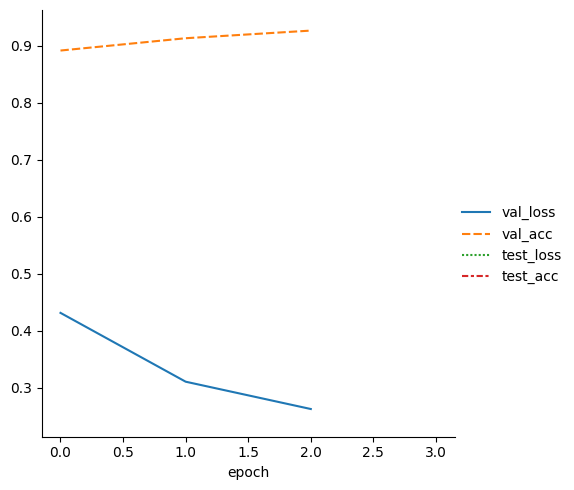

In [13]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")